# Figure 4. Vertical profiles of time mean diagnostics in the substellar region.

[Skip code and jump to the figure](#Show-the-figure)

In [1]:
import warnings

warnings.filterwarnings("ignore")
from dataclasses import dataclass
from typing import Optional

import iris
import matplotlib.pyplot as plt
import numpy as np
from aeolus.calc import calc_derived_cubes, meridional_mean, spatial_mean
from aeolus.io import load_data
from aeolus.model import lfric
from aeolus.plot import (
    add_custom_legend,
    all_sim_file_label,
    capitalise,
    figsave,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.region import Region

Local modules

In [2]:
import paths
from common import (
    CONST,
    DAYSIDE,
    DC,
    KW_ZERO_LINE,
    N_RES,
    NIGHTSIDE,
    SIMULATIONS,
)

Show all simulations

In [3]:
show_sim = [*SIMULATIONS.keys()]

## Load regridded time-mean data

In [4]:
# Combine two datasets into one cube list
dset = {}
for sim_label in show_sim:
    dset[sim_label] = dset[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_averages_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    calc_derived_cubes(dset[sim_label], const=CONST, model=lfric)
    dset[sim_label].extract_cube("rh_water").units = "%"  # fix unit notation

## Make plots

Define coordinate points and labels

In [5]:
lons = dset[sim_label].extract(DC.relax.x)[0].coord(lfric.x).points
lats = dset[sim_label].extract(DC.relax.y)[0].coord(lfric.y).points
heights = dset[sim_label].extract(DC.relax.z)[0].coord(lfric.z).points

coord_mappings = {
    "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
    "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    "level_height": dict(ticks=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25], units="km"),
}

Define spatial operations

In [6]:
@dataclass
class SpatialOp:
    recipe: callable
    title: str


SPATIAL_OP = {
    "d": SpatialOp(
        recipe=lambda cube: spatial_mean(cube.extract(DAYSIDE.constraint)),
        title="Day Side",
    ),
    "ss_pm05": SpatialOp(
        recipe=lambda cube: spatial_mean(cube.extract(Region(-5, 5, -5, 5).constraint)),
        title="Substellar Point $\pm5^\degree$",
    ),
    "ss_pm45": SpatialOp(
        recipe=lambda cube: spatial_mean(
            cube.extract(Region(-45, 45, -45, 45).constraint)
        ),
        title="Substellar Point $\pm45^\degree$",
    ),
    "n": SpatialOp(
        recipe=lambda cube: spatial_mean(cube.extract(NIGHTSIDE.constraint)),
        title="Night Side",
    ),
    "ss": SpatialOp(
        recipe=lambda cube: cube.interpolate(
            [(lfric.x, 0), (lfric.y, 0)], iris.analysis.Linear()
        ),
        title="Substellar Point",
    ),
    "as": SpatialOp(
        recipe=lambda cube: cube.interpolate(
            [(lfric.x, 180), (lfric.y, 0)], iris.analysis.Linear()
        ),
        title="Antistellar Point",
    ),
    "west_term": SpatialOp(
        recipe=lambda cube: meridional_mean(
            cube.extract(
                iris.Constraint(**{lfric.x: -90}),
            )
        ),
        title="Western (morning) terminator",
    ),
    "east_term": SpatialOp(
        recipe=lambda cube: meridional_mean(
            cube.extract(
                iris.Constraint(**{lfric.x: 90}),
            )
        ),
        title="Eastern (evening) terminator",
    ),
}

Define diagnostics

In [7]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    kw_axline: dict = None
    xscale: str = "linear"
    xlim: list = None
    inset_bounds: list = None
    inset_xlim: list = None
    inset_ylim: Optional = (0, 10)
    inset_yticks: Optional = (0, 2, 4, 6, 8, 10)


DIAGS = {
    "temp": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.temp),
        title="Temperature",
        units="$K$",
        # ss
        xlim=[170, 300],
        inset_xlim=[220, 295],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # d
        # xlim=[170, 270],
        # inset_xlim=[235, 265],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # west_term
        # xlim=[170, 265],
        # inset_xlim=[190, 260],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # east_term
        # xlim=[170, 280],
        # inset_xlim=[210, 270],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
    "theta": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.thta),
        title="Potential Temperature",
        units="$K$",
        xlim=[270, 500],
        inset_xlim=[280, 330],
        inset_bounds=[0.1, 0.55, 0.4, 0.4],
    ),
    "lapse_rate": Diag(
        recipe=lambda cl: d_dz(cl.extract_cube(lfric.temp), model=lfric),
        title="Lapse Rate",
        units="$K$ $km^{-1}$",
        kw_axline=dict(xy1=(0, 0), xy2=(0, 1)),
        # xlim=[-11, 3],
        # inset_xlim=[-10, -4],
        # inset_bounds=[0.35, 0.55, 0.4, 0.4],
        xlim=[-12, 3],
        inset_xlim=[-11, -2],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
    ),
    "dtheta_dz": Diag(
        recipe=lambda cl: d_dz(cl.extract_cube(lfric.thta), model=lfric),
        title=r"$d\theta/dz$",
        units="$K$ $km^{-1}$",
        kw_axline=dict(xy1=(0, 0), xy2=(0, 1)),
        xlim=[-1.5, 20],
        inset_xlim=[-1, 7],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
        inset_ylim=(0, 19),
        inset_yticks=(0, 2, 4, 6, 8, 10, 12, 14, 16, 18),
    ),
    "w": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.w),
        title="Upward Velocity",
        units="$cm$ $s^{-1}$",
        kw_axline=dict(xy1=(0, 0), xy2=(0, 1)),
        xlim=[-1, 10],
        inset_xlim=[-0.5, 9.5],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
        inset_ylim=(0, 19),
        inset_yticks=(0, 2, 4, 6, 8, 10, 12, 14, 16, 18),
    ),
    "m_v": Diag(
        recipe=lambda cl: cl.extract_cube("m_v"),
        title="Water Vapour Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        xscale="log",
        xlim=[1e-7, 3e-2],
        inset_xlim=[1e-4, 2e-2],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
    ),
    "m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("m_cl"),
        title="Cloud Liquid Mixing Ratio",
        units="$g$ $kg^{-1}$",
        inset_xlim=[5e-7, 1e-4],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
    ),
    "m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("m_ci"),
        title="Cloud Ice Mixing Ratio",
        units="$g$ $kg^{-1}$",
        inset_xlim=[1e-5, 3e-4],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
    "bulk_fraction": Diag(
        recipe=lambda cl: cl.extract_cube("bulk_fraction"),
        title="Bulk Cloud Fraction",
        units="%",
        xscale="linear",
        # ss
        xlim=[0, 100],
        inset_xlim=[0.1, 0.9],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
    "rh_water": Diag(
        recipe=lambda cl: cl.extract_cube("rh_water"),
        title="Relative Humidity",
        # title="RH w.r.t. Liquid",
        units="%",
        xscale="linear",
        xlim=[0, 100],
        inset_xlim=[10, 90],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
}

Assemble the figure using selected diagnostics

In [8]:
add_inset = False
diag_keys = ["temp", "m_v", "rh_water", "m_cl", "m_ci", "bulk_fraction"]
ncols = 3
so_key = "ss_pm45"

kw_common = dict(
    markevery=5,
    markersize=5,
    markeredgecolor="w",
    markeredgewidth=0.5,
)

fig = plt.figure(figsize=(8, 3 * (len(diag_keys) // ncols)), layout="constrained")
axd = fig.subplot_mosaic(
    [diag_keys[i : i + ncols] for i in range(0, len(diag_keys), ncols)]
    # [diag_keys[i : i + 2] for i in range(0, len(diag_keys), 2)],
    # gridspec_kw={"wspace": 0.1, "hspace": 0.4},
)
iletters = subplot_label_generator()
for diag_key in diag_keys:
    ax = axd[diag_key]
    axes = [ax]
    if add_inset:
        axins = ax.inset_axes(DIAGS[diag_key].inset_bounds)
        axes.append(axins)
    for isim, sim_label in enumerate(show_sim):
        cube = SPATIAL_OP[so_key].recipe(DIAGS[diag_key].recipe(dset[sim_label]))
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        if iris.util.is_masked(cube.data):
            continue
        (y,) = cube.dim_coords
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        for _ax in axes:
            if kw_axline := DIAGS[diag_key].kw_axline:
                _ax.axline(**kw_axline, **KW_ZERO_LINE)
            _ax.plot(
                cube.data,
                y.points,
                **kw_common,
                **SIMULATIONS[sim_label].kw_plt,
            )

    ax.set_title(
        f"({next(iletters)})",
        loc="left",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_title(
        f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]",
        loc="right",
        fontdict={"weight": "bold"},
        pad=3,
    )
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(f"{capitalise(y.name())} [{y.units}]", size="medium", labelpad=1)
    if not ax.get_subplotspec().is_first_col():
        ax.set(ylabel="")
    ax.set(
        xscale=getattr(DIAGS[diag_key], "xscale", "linear"),
        xlim=getattr(DIAGS[diag_key], "xlim", None),
    )
    if add_inset:
        axins.set(
            xscale=getattr(DIAGS[diag_key], "xscale", "linear"),
            xlim=getattr(DIAGS[diag_key], "inset_xlim", None),
            yscale="linear",
            ylim=DIAGS[diag_key].inset_ylim,
            yticks=DIAGS[diag_key].inset_yticks,
        )
        mark_inset(
            ax,
            axins,
            loc1=1 if DIAGS[diag_key].inset_bounds[0] < 0.5 else 2,
            loc2=3 if DIAGS[diag_key].inset_bounds[0] < 0.5 else 4,
            edgecolor="0.75",
        )

add_custom_legend(
    fig,
    {
        SIMULATIONS[sim_label].title: {**kw_common, **SIMULATIONS[sim_label].kw_plt}
        for sim_label in show_sim
    },
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize="medium",
    title_fontsize="large",
    title=f"Time-mean Vertical Profiles at the {SPATIAL_OP[so_key].title}",
    bbox_to_anchor=(0.5, 1.075),
)

plt.close()

# Show the figure

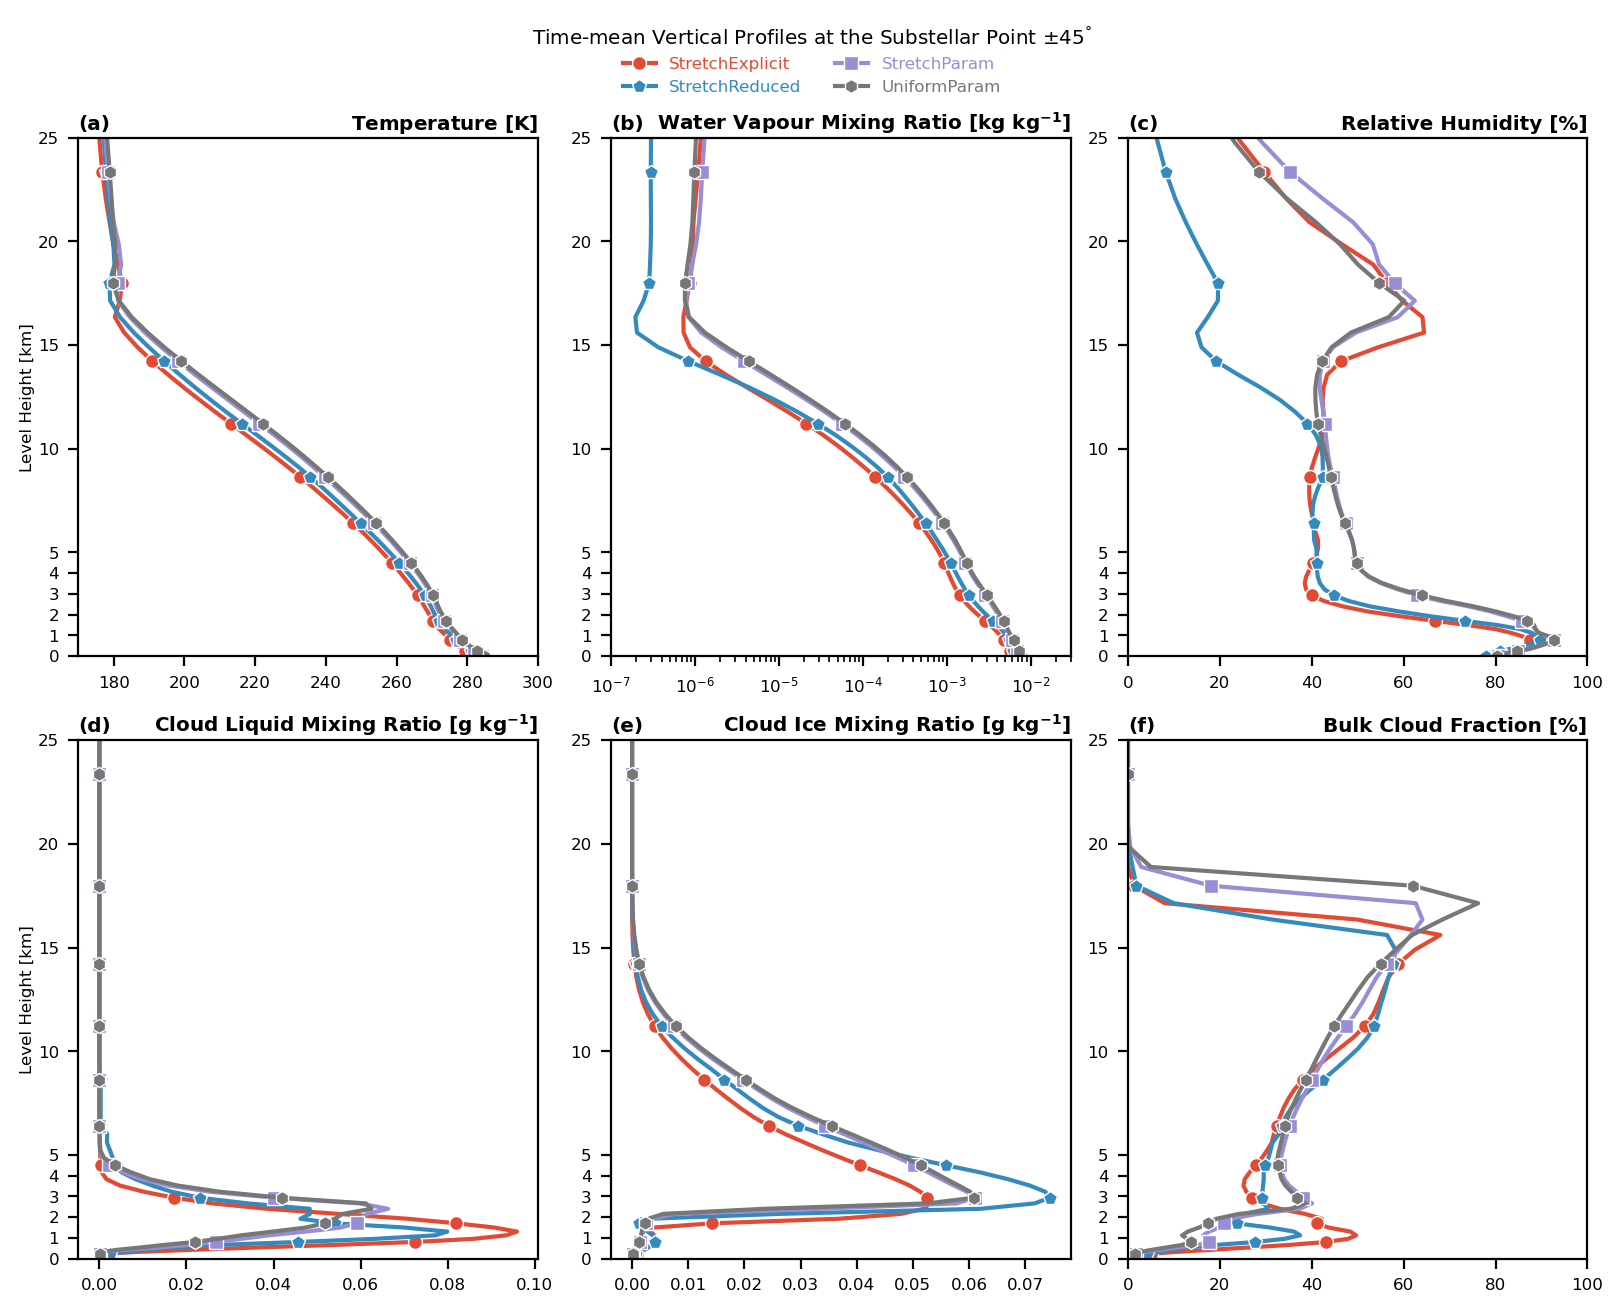

In [9]:
fig

- **Vertical profiles of time mean diagnostics in the substellar region within the bottom 25 km of the atmosphere**
- **(a) temperature in $K$, (b) water vapor mixing ratio in $kg$ $kg^{-1}$ , (c) relative humidity in %, (d) cloud liquid mixing ratio in $g$ $kg^{-1}$, (e) cloud ice mixing ratio in $g$ $kg^{-1}$, (f) cloud fraction in %.**
- **_StretchExplicit_ is shown in red, _StretchReduced_ in blue, _StretchParam_ in purple, and _UniformParam_ in gray.**

In [10]:
# and save it
figsave(
    fig,
    paths.figures
    / f"regr__{all_sim_file_label(show_sim)}__{'_'.join(diag_keys)}__tm_{so_key}",
)

Saved to ../figures/regr__hab1_mod_c192_s10e_s10r_s10p_p__temp_m_v_rh_water_m_cl_m_ci_bulk_fraction__tm_ss_pm45.pdf
Size: 52.2 KB
